In [1]:
dataset_directory = '../dataset'
validation_directory = dataset_directory + '/validation'
train_directory = dataset_directory + '/train'

In [2]:
from keras.utils import image_dataset_from_directory

image_size = (256, 256)

train_dataset = image_dataset_from_directory(
    train_directory,
    label_mode = 'categorical',
    image_size = image_size,
    batch_size = 64,
    shuffle = True
)

validation_dataset = image_dataset_from_directory(
    validation_directory,
    label_mode = 'categorical',
    image_size = image_size,
    batch_size = 64,
    shuffle = True
)

Found 9423 files belonging to 3 classes.
Found 2353 files belonging to 3 classes.


In [3]:
from keras.applications import InceptionV3

base_model = InceptionV3 (
    weights = 'imagenet',
    include_top = False,
    input_shape = image_size + (3,)
)

base_model.trainable = False

In [5]:
from keras.models import Sequential
from keras.layers import InputLayer, Rescaling, RandomFlip, RandomRotation, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout, Dense

model = Sequential (
    [
        InputLayer(input_shape = image_size + (3,)),

        Rescaling(1./255),
        RandomFlip('horizontal_and_vertical'),
        RandomRotation(factor=0.4, fill_mode='wrap'),

        base_model,

        GlobalAveragePooling2D(),
        Flatten(),

        Dense(64, activation='elu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='elu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(3, activation='softmax')
    ]
)

In [6]:
from keras.optimizers import Adam

model.compile (
    optimizer = Adam(),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [7]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = '../models/inception-v3-model.keras',
    monitor ='val_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs = 5,
    validation_data = validation_dataset,
    callbacks = [checkpoint]
)

In [13]:
from keras.models import load_model

model = load_model('../models/inception-v3-model.keras')

In [14]:
start_tunning_at = len(base_model.layers) - int(0.3 * len(base_model.layers))

print(f"Number of layers in the base model: {len(base_model.layers)}")
print(f"Number of layers to be fine-tuned: {len(base_model.layers) - start_tunning_at}")

Number of layers in the base model: 311
Number of layers to be fine-tuned: 93


In [15]:
for layer in base_model.layers[start_tunning_at:]:
    layer.trainable = True

In [16]:
from keras.optimizers import Adam

model.compile (
    optimizer = Adam(),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = [checkpoint]
)

In [ ]:
from keras.models import load_model
model = load_model('../models/inception-v3-model.keras')

2/2 [==============================] - 4s 2s/step


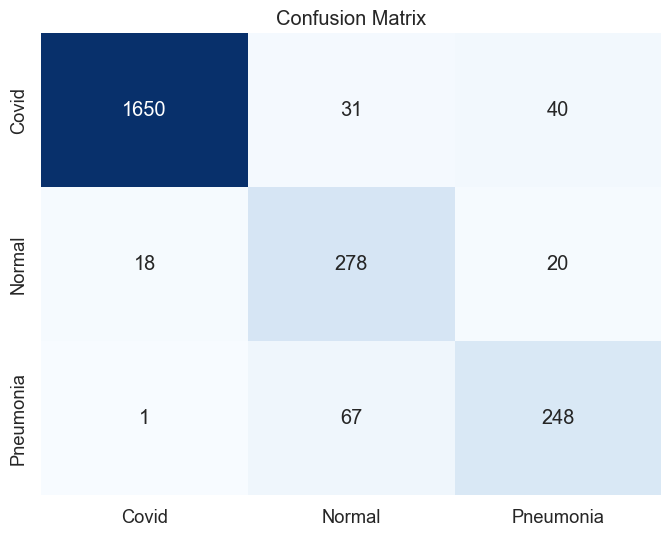

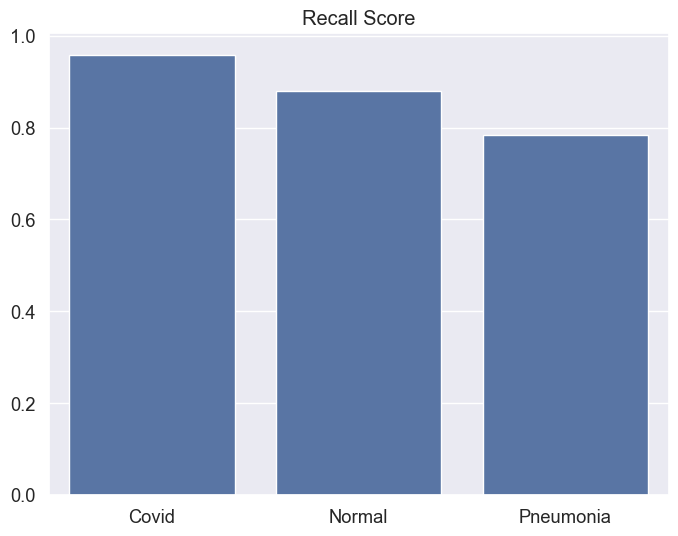

Covid: 0.9587
Normal: 0.8797
Pneumonia: 0.7848


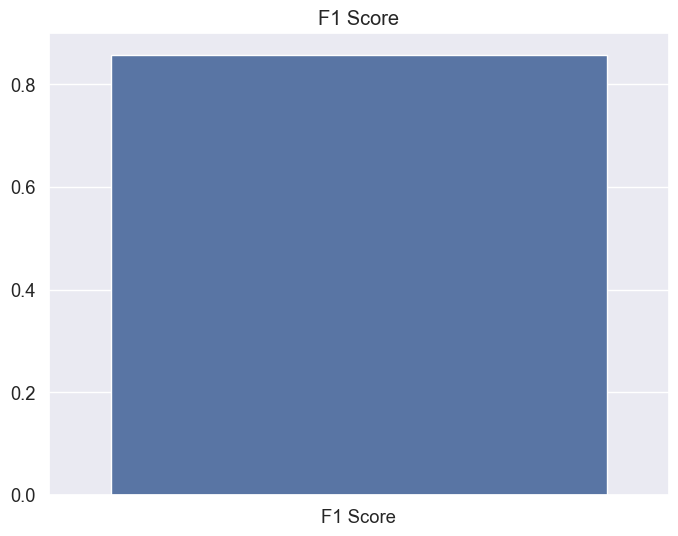

F1-Score: 0.8573


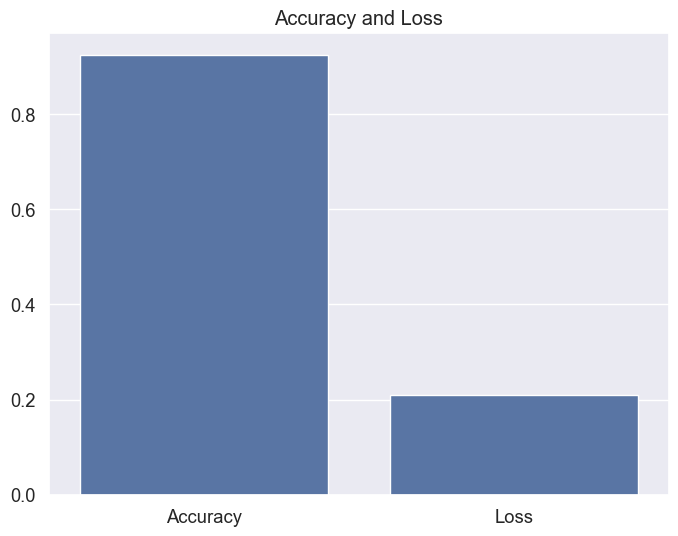

Accuracy: 0.9248 | Loss: 0.2101


In [4]:
from utils.evaluate_model import evaluate_model
evaluate_model(model, validation_dataset)